In [844]:
# This is a notebook to analyse dataset for internet customers.

In [845]:
# Local all required packages
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, fbeta_score
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [846]:
# Add function definitions
def radarplot(df, norm_max=False):
    df = df.copy()
    if norm_max:
        df /= df.max()

    angles = np.linspace(0, 2 * np.pi, len(df.columns), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))  # close the plot

    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)

    for i in df.index:
        stats = df.loc[i, :].values
        stats = np.concatenate((stats, [stats[0]]))  # close the plot
        ax.plot(angles, stats, 'o-', linewidth=2, label=i)
        ax.fill(angles, stats, alpha=0.25)

    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    columns = list(df.columns) + list(df.columns[:1])
    # print((angles * 180 / np.pi).shape, len(columns))
    ax.set_thetagrids(angles * 180 / np.pi, columns)
    ax.grid(True)
    return ax

In [847]:
# Load the dataset
data = pd.read_csv("BP_DS_Challenge.csv")
data[:5]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [848]:
# Dataset cleaning
data['TotalCharges'] = data['TotalCharges'].replace(" ", 0)
data['SeniorCitizen']= data['SeniorCitizen'].astype(str)
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'])
data = data.drop(columns="customerID")

In [849]:
pd.concat([data.dtypes.to_frame().rename(columns={0: "type"}), data.nunique().to_frame().rename(columns={0: "unique_num"})], axis=1)

,type,unique_num
gender,object,2
SeniorCitizen,object,2
Partner,object,2
Dependents,object,2
tenure,int64,73
PhoneService,object,2
MultipleLines,object,3
InternetService,object,3
OnlineSecurity,object,3
OnlineBackup,object,3


In [850]:
# Extract the independent variables and save as array in X
X = data.iloc[:,:-1].values
pd.DataFrame(X[:1])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85


In [851]:
# Extract the dependent variable and save as array in Y
Y = data.iloc[:,-1].values
pd.DataFrame(Y[:1])

,0
0,No


In [852]:
# Encode the two-value columns using LabelEncoding and the multi-value columns using one hot encoder
LE1 = LabelEncoder()
multi_value_categorical = []
numerical_cols = []
for i in range(data.shape[1]-1):
    col_type = str(data.dtypes[i])
    col_name = str(data.columns[i])
    col_unique_values = str(data.nunique()[i])       
    print(str(i) + " " +col_type + " " + col_name + " " + col_unique_values)
    if col_type == 'object':
        if col_unique_values == '2':
            X[:,i] = np.array(LE1.fit_transform(X[:,i]))
        else:
            multi_value_categorical.append(i)
    else:
        numerical_cols.append(i)
ct = ColumnTransformer(transformers=[('encoder',OneHotEncoder(),[6, 7, 8, 9, 10, 11, 12, 13, 14, 16])],remainder="passthrough")
X = np.array(ct.fit_transform(X))
Y[:] = np.array(LE1.fit_transform(Y[:]))

0 object gender 2
1 object SeniorCitizen 2
2 object Partner 2
3 object Dependents 2
4 int64 tenure 73
5 object PhoneService 2
6 object MultipleLines 3
7 object InternetService 3
8 object OnlineSecurity 3
9 object OnlineBackup 3
10 object DeviceProtection 3
11 object TechSupport 3
12 object StreamingTV 3
13 object StreamingMovies 3
14 object Contract 3
15 object PaperlessBilling 2
16 object PaymentMethod 4
17 float64 MonthlyCharges 1585
18 float64 TotalCharges 6531


In [853]:
pd.DataFrame(X[:1])

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0,0,1,0,1,0,1,29.85,29.85


In [854]:
# Apply feature selection. This step significantly improves the results:
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
X = sel.fit_transform(X)

# ANOVA feature selection for numeric input and categorical output
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
# define feature selection
fs = SelectKBest(score_func=f_classif, k=30)
# apply feature selection
X = fs.fit_transform(X, Y)
print(X.shape)

In [855]:
pd.DataFrame(X[:1])

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0,1,0,1,1,29.85,29.85


In [856]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=0)
X_train = np.asarray(X_train).astype(np.float32)
Y_train = np.asarray(Y_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
Y_test = np.asarray(Y_test).astype(np.float32)

In [857]:
# Normalise the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

In [858]:
ann = tf.keras.models.Sequential()

In [859]:
ann.add(tf.keras.layers.Dense(units=50,activation="relu"))
ann.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))

In [860]:
optimizer = tf.keras.optimizers.SGD()

In [861]:
ann.compile(optimizer, loss="mse", metrics=["mae", "acc"])

In [862]:
history = ann.fit(X_train,Y_train,batch_size=32,epochs = 200)

Epoch 1/200
177/177 [==============================] - 1s 2ms/step - loss: 0.2113 - mae: 0.4234 - acc: 0.6494
Epoch 2/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1695 - mae: 0.3621 - acc: 0.7428
Epoch 3/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1563 - mae: 0.3366 - acc: 0.7684
Epoch 4/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1501 - mae: 0.3222 - acc: 0.7796
Epoch 5/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1465 - mae: 0.3134 - acc: 0.7893
Epoch 6/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1443 - mae: 0.3065 - acc: 0.7907
Epoch 7/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1429 - mae: 0.3020 - acc: 0.7922
Epoch 8/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1418 - mae: 0.2971 - acc: 0.7945
Epoch 9/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1409 - mae: 0.2945 - acc: 0.7943
Epoch 10/2

177/177 [==============================] - 0s 2ms/step - loss: 0.1316 - mae: 0.2674 - acc: 0.8111
Epoch 75/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1315 - mae: 0.2675 - acc: 0.8113
Epoch 76/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1315 - mae: 0.2679 - acc: 0.8101
Epoch 77/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1314 - mae: 0.2672 - acc: 0.8108
Epoch 78/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1313 - mae: 0.2669 - acc: 0.8111
Epoch 79/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1313 - mae: 0.2665 - acc: 0.8111
Epoch 80/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1313 - mae: 0.2667 - acc: 0.8104
Epoch 81/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1312 - mae: 0.2673 - acc: 0.8108
Epoch 82/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1311 - mae: 0.2665 - acc: 0.8103
Epoch 83/200
1

177/177 [==============================] - 0s 2ms/step - loss: 0.1285 - mae: 0.2605 - acc: 0.8159
Epoch 148/200
177/177 [==============================] - 0s 1ms/step - loss: 0.1285 - mae: 0.2603 - acc: 0.8163
Epoch 149/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1285 - mae: 0.2599 - acc: 0.8154
Epoch 150/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1284 - mae: 0.2606 - acc: 0.8172
Epoch 151/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1284 - mae: 0.2605 - acc: 0.8170
Epoch 152/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1283 - mae: 0.2599 - acc: 0.8165
Epoch 153/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1283 - mae: 0.2600 - acc: 0.8156
Epoch 154/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1283 - mae: 0.2608 - acc: 0.8163
Epoch 155/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1283 - mae: 0.2605 - acc: 0.8154
Epoch 

In [863]:
lreg = LogisticRegression(random_state = 0)
lreg.fit(X_train, Y_train)

LogisticRegression(random_state=0)

In [864]:
ypred = {}
ypred["ANN"] = ann.predict(X_test)
ypred["Regression"] = [x[1] for x in lreg.predict_proba(X_test)]

ANN
Regression


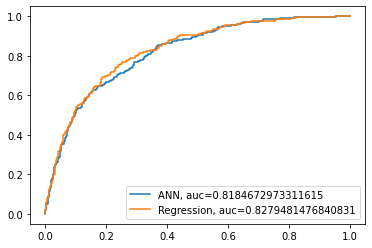

In [865]:
results = {}
for method, predictions in ypred.items():
    print(method)
    fpr, tpr, _ = metrics.roc_curve(Y_test, predictions)
    auc = metrics.roc_auc_score(Y_test, predictions)
    plt.plot(fpr,tpr,label=method + ", auc="+str(auc))
    results[method] = [str(auc)]
plt.legend(loc=4)
plt.show()

In [866]:
for method, predictions in ypred.items():
    preds = []
    for x in predictions:
        if x <= 0.5:
            preds.append(0.0)
        else:
            preds.append(1.0)
    acc = accuracy_score(Y_test, preds )
    prec = precision_score(Y_test, preds )
    rec = recall_score(Y_test, preds )
    f1 = f1_score(Y_test, preds )
    f2 = fbeta_score(Y_test, preds, beta=2.0)
    results[method] = np.concatenate((results[method], [acc, prec, rec, f1, f2]))

In [867]:
results_df = pd.DataFrame(results, index=["auc", "acc", "prec", "rec", "f1", "f2"]).transpose()

In [868]:
results_df = results_df.apply(pd.to_numeric)

In [869]:
results_df

,auc,acc,prec,rec,f1,f2
ANN,0.818467,0.797729,0.635179,0.529891,0.577778,0.548061
Regression,0.827948,0.804826,0.653465,0.538043,0.590164,0.557746


<PolarAxesSubplot:>

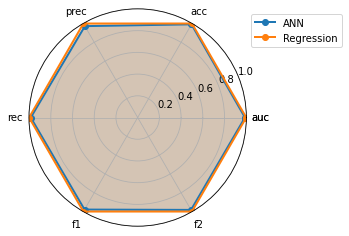

In [870]:
# Visualise the offline evaluation results
radarplot(results_df, norm_max=True)